In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import multivariate_normal
from sklearn.neighbors import KNeighborsClassifier

# Environment

#### Noisy Cart Pole

This is the noisy version of the CartPole-v0 environment of OpenAI.  
https://gym.openai.com/envs/CartPole-v0  
https://github.com/openai/gym/wiki/CartPole-v0  


In [2]:
class NoisyCartPoleEnvironment:
    
    stateDimension = 4
    actionDimension = 1
    actionSpace = range(2)
    transitionSigmas = [ 1e-2, 1e-5, 1e-2, 1e-5 ]
    
    def __init__(self):
        pass
    
    def cartpole_reset(self):
        state = np.random.uniform(low=-0.05, high=0.05, size=(4,))
        return np.array(state)
    
    # Extracted from OpenAI environment CartPole-v0
    def cartpole_step(self, state, action):

        gravity = 9.8
        masscart = 1.0
        masspole = 0.1
        total_mass = (masspole + masscart)
        length = 0.5 # actually half the pole's length
        polemass_length = (masspole * length)
        force_mag = 10.0
        tau = 0.02  # seconds between state updates

        # Angle at which to fail the episode
        theta_threshold_radians = 12 * 2 * math.pi / 360
        x_threshold = 2.4

        x, x_dot, theta, theta_dot = state

        already_done =  x < -x_threshold \
            or x > x_threshold \
            or theta < -theta_threshold_radians \
            or theta > theta_threshold_radians
        already_done = bool(already_done)

        if already_done:

            next_state = state
            reward = 0
            done = True

        else:

            force = force_mag if action==1 else -force_mag
            costheta = math.cos(theta)
            sintheta = math.sin(theta)
            temp = (force + polemass_length * theta_dot * theta_dot * sintheta) / total_mass
            thetaacc = (gravity * sintheta - costheta* temp) / (length * (4.0/3.0 - masspole * costheta * costheta / total_mass))
            xacc  = temp - polemass_length * thetaacc * costheta / total_mass
            x  = x + tau * x_dot
            x_dot = x_dot + tau * xacc
            theta = theta + tau * theta_dot
            theta_dot = theta_dot + tau * thetaacc
            next_state = np.array([x,x_dot,theta,theta_dot])

            reward = 1

            done =  x < -x_threshold \
                or x > x_threshold \
                or theta < -theta_threshold_radians \
                or theta > theta_threshold_radians
            done = bool(done)

        return next_state, reward, done, {}
    
    def noisycartpole_reset(self):
        return self.cartpole_reset()

    def noisycartpole_step(self, state, action):

        next_state_mean, reward, done, info = self.cartpole_step(state, action)   # CartPole Step

        noise = np.zeros(self.stateDimension)
        if not done:
            noise = np.random.randn(self.stateDimension) * self.transitionSigmas        # Adding Noise
        next_state = next_state_mean + noise

        logp = multivariate_normal.logpdf(next_state, mean=next_state_mean, cov=np.diagflat(self.transitionSigmas))

        return next_state, reward, done, logp
    
    def reset(self):
        return self.noisycartpole_reset()
    
    def step(self, state, action):
        return self.noisycartpole_step(state, action)
    

In [3]:
env = NoisyCartPoleEnvironment()

# Utility Functions

In [4]:
def trajectory2tuples(states, actions):

    # Dimensions
    [sample_count, horizon, state_dimension] = states.shape
    [_, _, action_dimension] = actions.shape

    # Reshape Inputs and Targets
    inputs = np.reshape(states, (sample_count*horizon, state_dimension))
    targets = np.reshape(actions, (sample_count*horizon, action_dimension))

    return inputs, targets

In [5]:
def plot_trajectories(states, color='red', n=0):

    [sample_count, _, _] = states.shape

    if n==0:
        samples_drawn = range(sample_count)
    else:
        samples_drawn = np.random.choice(sample_count, n)
        
    for s in samples_drawn:
        plt.plot(states[s, :, 0], states[s, :, 2], '-', color=color)
        plt.plot(states[s, :, 0], states[s, :, 2], 'o', color=color, markersize=2)
        plt.plot(states[s, -1, 0], states[s, -1, 2], 'o', color=color, markersize=5)

In [6]:
def plot_iteration(states, selected=None, n=0):
    plot_trajectories(states, color='red', n=n)
    if selected is not None:
        plot_trajectories(selected, color='green', n=n)
    
    plt.vlines(0, -0.25, 0.25, linestyle='dotted')
    # plt.vlines(2.4, -0.25, 0.25, linestyle='dotted')
    # plt.vlines(-2.4, -0.25, 0.25, linestyle='dotted')
    
    plt.hlines(0, -2.4, 2.4, linestyle='dotted')
    plt.hlines(0.21, -2.4, 2.4, linestyle='dotted')
    plt.hlines(-0.21, -2.4, 2.4, linestyle='dotted')
    
    plt.grid()
    plt.show()

In [7]:
def rollout_trajectories(env, policy, horizon, sample_count=1, init=None):

    # States and Actions
    states = np.zeros((sample_count, horizon, env.stateDimension))
    actions = np.zeros((sample_count, horizon, env.actionDimension))
    rewards = np.zeros((sample_count, horizon))
    logp = np.zeros(sample_count)
    
    # Sample Trajectories
    for t in range(horizon):
        
        logp_step_transition = np.zeros((sample_count))

        # Initialization
        if t == 0:
            if init is None:
                states[:,t,:] = [ env.reset() for i in range(sample_count) ]
            else:
                states[:,t,:] = init
                
        # Transition and Reward
        else:
            for s in range(sample_count):
                states[s, t, :], rewards[s,t-1], _1, logp_step_transition[s] = env.step(states[s, t-1, :], actions[s, t-1, :])
        
        # Action Selection
        actions_unshaped, logp_step_policy = policy.query(states[:, t, :])
        actions[:,t,:] = actions_unshaped.reshape(sample_count, env.actionDimension)
        
        # Log Probability of Sampling
        logp += logp_step_transition + logp_step_policy
        
    for s in range(sample_count):
        _, rewards[s, horizon-1], _1, _2 = env.step(states[s, horizon-1, :], actions[s, horizon-1, :])
    
    return states, actions, rewards, logp

# Policy

In [8]:
class SciKitPolicy():

    def __init__(self):
        raise NotImplementedError()

    def query(self, states):
        if len(states.shape) == 1:
            states = states.reshape(1, -1)
        return self.method.predict(states), np.zeros(states.shape[0])

    def train(self, inputs, targets):
        self.method.fit(inputs, targets)

    def m_step(self, states, actions):

        # States/Actions -> Inputs/Targets
        inputs, targets = trajectory2tuples(states, actions)

        # Train kNN
        self.train(inputs, targets.ravel())

In [9]:
class KnnPolicyDiscrete(SciKitPolicy):
    def __init__(self, k, weights='distance'):
        self.method = KNeighborsClassifier(n_neighbors=k, weights=weights, n_jobs=1)

In [10]:
class UniformPolicyDiscrete():

    def __init__(self, choices):
        self.choices = choices

    def query(self, states):
        return np.random.choice(self.choices, size=states.shape[0]), np.zeros(states.shape[0])

# Monte Carlo Sampling Method

In [11]:
temperatures = [0, 0.5, 1, 5, 10]
temperature_count = len(temperatures)

def eta(n):
    return temperatures[n]

In [12]:
def kernel_noop(env, policy, states_prev, actions_prev, rewards_prev, logp_prev):
    return states_prev, actions_prev, rewards_prev, logp_prev, [int(x) for x in range(sample_count)]

In [13]:
def kernel_prior(env, policy, states_prev, actions_prev, rewards_prev, logp_prev):
    
    ancestors = [np.random.randint(sample_count) for x in range(sample_count)]
    states, actions, rewards, logp = rollout_trajectories(env, policy, horizon, sample_count)
    
    return states, actions, rewards, logp, ancestors

In [20]:
def smcs(env, policy):
    
    states = np.zeros((temperature_count, sample_count, horizon, env.stateDimension))
    actions = np.zeros((temperature_count, sample_count, horizon, env.actionDimension))
    rewards = np.zeros((temperature_count, sample_count, horizon))
    logp = np.zeros((temperature_count, sample_count))
    ancestors = np.zeros((temperature_count, sample_count))

    for n in range(temperature_count):
    
        if n == 0:
            # Initial Trajectories
            states[n], actions[n], rewards[n], logp[n] = \
                rollout_trajectories(env, policy, horizon, sample_count)
        else:
            # Proposing New Trajectories
            states[n], actions[n], rewards[n], logp[n], ancestors[n] = \
                kernel_prior(env, policy, states[n-1], actions[n-1], rewards[n-1], logp[n-1] )
            
            # Weight Calculation
            total_rewards = np.sum(rewards[n],axis=1) / horizon
            total_rewards_ancestors = np.sum(rewards[n],axis=1) / horizon
            
            weights = ( total_rewards ** eta(n) / total_rewards_ancestors ** eta(n-1) ) \
                * np.exp(logp[n] - logp[n-1,ancestors[n-1].astype(int)])
            
            # Resampling
            weights = weights / np.sum(weights)
            selected = np.random.choice(range(sample_count), size=sample_count, p=weights, replace=True)

            states[n] = states[n,selected]
            actions[n] = actions[n,selected]
            rewards[n] = rewards[n,selected]
            logp[n] = logp[n,selected]
            ancestors[n] = ancestors[n,selected]
        
    return states[-1], actions[-1], rewards[-1]

# Parameters

In [25]:
# Environment  
horizon = 250

# Inference
iteration_count = 50
sample_count = 100

# Policy
kNearest = 5
policy_sample_count = sample_count
selectedPolicy = KnnPolicyDiscrete(kNearest)

# Plot
rendering_enabled = False

# RLEMMC

In [26]:
iteration_rewards = []

for i in range(iteration_count):
    
    if i == 0:
        iteration_policy = UniformPolicyDiscrete(env.actionSpace)
    else:
        iteration_policy = selectedPolicy
    
    # E-Step
    [states, actions, rewards] = smcs(env, iteration_policy)

    # M-Step
    selectedPolicy.m_step(states, actions)
        
    # Average Reward
    iteration_rewards.append(np.mean(rewards) * horizon)
    print( f'Iteration {i+1} - Average Reward : {iteration_rewards[i]}' )

Iteration 1 - Average Reward : 44.46
Iteration 2 - Average Reward : 127.07
Iteration 3 - Average Reward : 145.65
Iteration 4 - Average Reward : 188.76000000000002
Iteration 5 - Average Reward : 203.08
Iteration 6 - Average Reward : 215.57000000000002
Iteration 7 - Average Reward : 211.38000000000002
Iteration 8 - Average Reward : 221.58
Iteration 9 - Average Reward : 227.54
Iteration 10 - Average Reward : 224.89999999999998
Iteration 11 - Average Reward : 232.45
Iteration 12 - Average Reward : 232.81
Iteration 13 - Average Reward : 232.71
Iteration 14 - Average Reward : 235.25
Iteration 15 - Average Reward : 230.08999999999997
Iteration 16 - Average Reward : 231.04
Iteration 17 - Average Reward : 225.06
Iteration 18 - Average Reward : 233.61
Iteration 19 - Average Reward : 229.71
Iteration 20 - Average Reward : 240.27
Iteration 21 - Average Reward : 228.02
Iteration 22 - Average Reward : 229.66
Iteration 23 - Average Reward : 233.86
Iteration 24 - Average Reward : 230.43
Iteration 25 -

# Plots

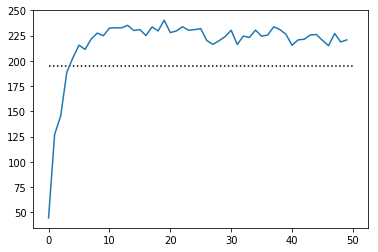

In [27]:
plt.plot(iteration_rewards)
plt.hlines(np.min([horizon,195]), 0, iteration_count, linestyle='dotted')
plt.show()

# Rendering

In [28]:
from IPython import display
def render_state(env, t):
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Timestep : %s" %(env.spec.id, t))
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [29]:
if rendering_enabled:
    env = gym.make('CartPole-v0')

    state = env.reset()
    for t in range(horizon):
        render_state(env,t)
        state,_,done,_ = env.step(int(iteration_policy.query(state)))
        if done:
            break        
    render_state(env,t)

    env.render(close=True)
    plt.close()